In [1]:
%pip install -r requirements.txt

INFO: pip is looking at multiple versions of numba to determine which version is compatible with other requirements. This could take a while.
   ---------------------------------------- 0.0/8.1 MB ? eta -:--:--
   -- ------------------------------------- 0.5/8.1 MB 4.2 MB/s eta 0:00:02
   --------- ------------------------------ 1.8/8.1 MB 7.2 MB/s eta 0:00:01
   -------------- ------------------------- 2.9/8.1 MB 5.4 MB/s eta 0:00:01
   -------------------------- ------------- 5.2/8.1 MB 7.2 MB/s eta 0:00:01
   -------------------------------- ------- 6.6/8.1 MB 6.8 MB/s eta 0:00:01
   ---------------------------------------- 8.1/8.1 MB 7.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/12.6 MB ? eta -:--:--
   ------ --------------------------------- 2.1/12.6 MB 10.7 MB/s eta 0:00:01
   ------------- -------------------------- 4.2/12.6 MB 10.1 MB/s eta 0:00:01
   ----------------------- ---------------- 7.3/12.6 MB 11.6 MB/s eta 0:00:01
   --------------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.19.0 requires numpy<2.2.0,>=1.26.0, but you have numpy 2.2.4 which is incompatible.


In [2]:
import pandas as pd
import numpy as np
import suncalc
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.calibration import LabelEncoder
import torch.nn as nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from sklearn.metrics import confusion_matrix, accuracy_score
from copy import deepcopy
from pyts.image import GramianAngularField

# Task 1: Exploratory Data Analysis (EDA) and Preprocessing

The preprocessing approach began by removing several features deemed less relevant for initial analysis based on their descriptions in the dataset README, including forecast data, capacity data, and bidding zone price data, focusing primarily on actual load and generation values. 

Missing values in the *DK_solar_generation_actual* column were imputed by setting solar generation to zero during nighttime hours, determined using the `suncalc` library. 

A `Principal Component Analysis (PCA)` was then applied to the wind generation features (*DK_wind_generation_actual*, *DK_wind_onshore_generation_actual*, *DK_wind_offshore_generation_actual*) to reduce dimensionality and create a single *DK_wind_pca* feature representing overall wind generation. 

The data was then reshaped into daily arrays containing hourly measurements for total load, solar generation, and the wind `PCA` component. Finally, the dataset was split into training, validation, and testing sets while ensuring that the data was scaled using `StandardScaler` fitted on the training data to prepare for modeling.

## 1. Data Loading and Initial Inspection

In [3]:
raw_dataset = pd.read_csv("opsd_raw.csv")
# raw_dataset.info()

Denmark's power data is stored in columns prefixed with `DK_` in the `opsd_raw.csv` file.

In [4]:
raw_dataset['utc_timestamp'] = pd.to_datetime(raw_dataset['utc_timestamp'])
dk_data = raw_dataset.filter(regex='^DK_|utc_timestamp')
print(f"Denmark columns: {len(dk_data.columns)}")

Denmark columns: 18


## 2. Data Inspection

### Key Data Columns

Electricity Load Data
- `DK_load_actual_entsoe_transparency`

Renewable Generation


**Solar Power:**
- `DK_solar_generation_actual`

**Wind Power:**
- Total: `DK_wind_generation_actual`
- Offshore: `DK_wind_offshore_generation_actual` 
- Onshore: `DK_wind_onshore_generation_actual`

In [5]:
print(f"\nRaw data shape: {dk_data.shape}")
dk_data.head()


Raw data shape: (50400, 18)


,utc_timestamp,DK_load_actual_entsoe_transparency,DK_load_forecast_entsoe_transparency,DK_solar_capacity,DK_solar_generation_actual,DK_wind_capacity,DK_wind_generation_actual,DK_wind_offshore_capacity,DK_wind_offshore_generation_actual,DK_wind_onshore_capacity,DK_wind_onshore_generation_actual,DK_1_load_actual_entsoe_transparency,DK_1_load_forecast_entsoe_transparency,DK_1_price_day_ahead,DK_1_wind_onshore_generation_actual,DK_2_load_actual_entsoe_transparency,DK_2_load_forecast_entsoe_transparency,DK_2_price_day_ahead
0,2015-01-01 00:00:00+00:00,NaN,NaN,489.0,NaN,4643.0,NaN,1264.0,NaN,3379.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 01:00:00+00:00,3100.02,3126.8,489.0,NaN,4643.0,2357.33,1264.0,902.71,3379.0,1454.62,1794.96,1784.9,16.04,1206.98,1305.06,1341.9,16.04
2,2015-01-01 02:00:00+00:00,2980.39,3019.0,489.0,NaN,4643.0,2387.35,1264.0,830.87,3379.0,1556.48,1744.76,1734.5,14.60,1352.40,1235.63,1284.5,14.60
3,2015-01-01 03:00:00+00:00,2933.49,2976.3,489.0,NaN,4643.0,2594.47,1264.0,915.43,3379.0,1679.04,1743.17,1734.0,14.95,1463.50,1190.32,1242.3,14.95
4,2015-01-01 04:00:00+00:00,2941.54,2982.5,489.0,0.01,4643.0,3092.01,1264.0,1056.28,3379.0,2035.73,1751.47,1753.1,14.50,1781.53,1190.07,1229.4,14.50


Let's delete the columns not related to Denmark power and energy production

In [6]:
columns_to_drop = [
    'DK_load_forecast_entsoe_transparency',
    'DK_solar_capacity',
    'DK_wind_capacity',
    'DK_wind_offshore_capacity',
    'DK_wind_onshore_capacity',
    'DK_1_load_actual_entsoe_transparency',
    'DK_1_load_forecast_entsoe_transparency',
    'DK_1_price_day_ahead',
    'DK_1_wind_onshore_generation_actual',
    'DK_2_load_actual_entsoe_transparency',
    'DK_2_load_forecast_entsoe_transparency',
    'DK_2_price_day_ahead'
]

dk_data = dk_data.drop(columns=columns_to_drop)

In [7]:
dk_data[dk_data.isna().any(axis=1)]

,utc_timestamp,DK_load_actual_entsoe_transparency,DK_solar_generation_actual,DK_wind_generation_actual,DK_wind_offshore_generation_actual,DK_wind_onshore_generation_actual
0,2015-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN
1,2015-01-01 01:00:00+00:00,3100.02,NaN,2357.33,902.71,1454.62
2,2015-01-01 02:00:00+00:00,2980.39,NaN,2387.35,830.87,1556.48
3,2015-01-01 03:00:00+00:00,2933.49,NaN,2594.47,915.43,1679.04
50393,2020-09-30 17:00:00+00:00,4444.53,NaN,1179.26,623.09,556.17
50394,2020-09-30 18:00:00+00:00,4370.39,NaN,1432.28,757.39,674.89
50395,2020-09-30 19:00:00+00:00,4057.22,NaN,1492.40,682.89,809.51
50396,2020-09-30 20:00:00+00:00,3523.75,NaN,1690.23,785.01,905.22
50397,2020-09-30 21:00:00+00:00,3114.95,NaN,1800.90,855.16,945.74
50398,2020-09-30 22:00:00+00:00,2926.36,NaN,2014.26,1023.25,991.01


Rows `0` and `50399` contain gaps in many columns, which makes them less useful for analysis and modeling, so they can be deleted.

In [8]:
dk_data = dk_data.dropna(how='all', subset=['DK_load_actual_entsoe_transparency', 'DK_solar_generation_actual', 'DK_wind_generation_actual', 'DK_wind_offshore_generation_actual', 'DK_wind_onshore_generation_actual'])

In [9]:
def is_night_suncalc(dt, lat, lon):
    """Determines whether the set time is at night using suncalc"""
    try:
        sun_times = suncalc.get_position(dt, lon, lat)
        altitude = sun_times['altitude']
        return altitude < 0
    except Exception as e:
        return True

def fill_solar_with_suncalc_vectorized(df, lat=55.676, lon=12.566):
    """Fills in the missing values in DK_solar_generation_actual using suncalc and vectorization"""

    is_night_vectorized = np.vectorize(is_night_suncalc)
    is_night_mask = is_night_vectorized(df['utc_timestamp'], lat, lon)
    df.loc[is_night_mask & df['DK_solar_generation_actual'].isna(), 'DK_solar_generation_actual'] = 0

    return df

dk_data = fill_solar_with_suncalc_vectorized(dk_data.copy())


In [10]:
print(dk_data.isnull().sum())

utc_timestamp                         0
DK_load_actual_entsoe_transparency    0
DK_solar_generation_actual            0
DK_wind_generation_actual             0
DK_wind_offshore_generation_actual    0
DK_wind_onshore_generation_actual     0
dtype: int64


In [11]:
wind_cols = [
    'DK_wind_generation_actual',
    'DK_wind_onshore_generation_actual',
    'DK_wind_offshore_generation_actual'
]

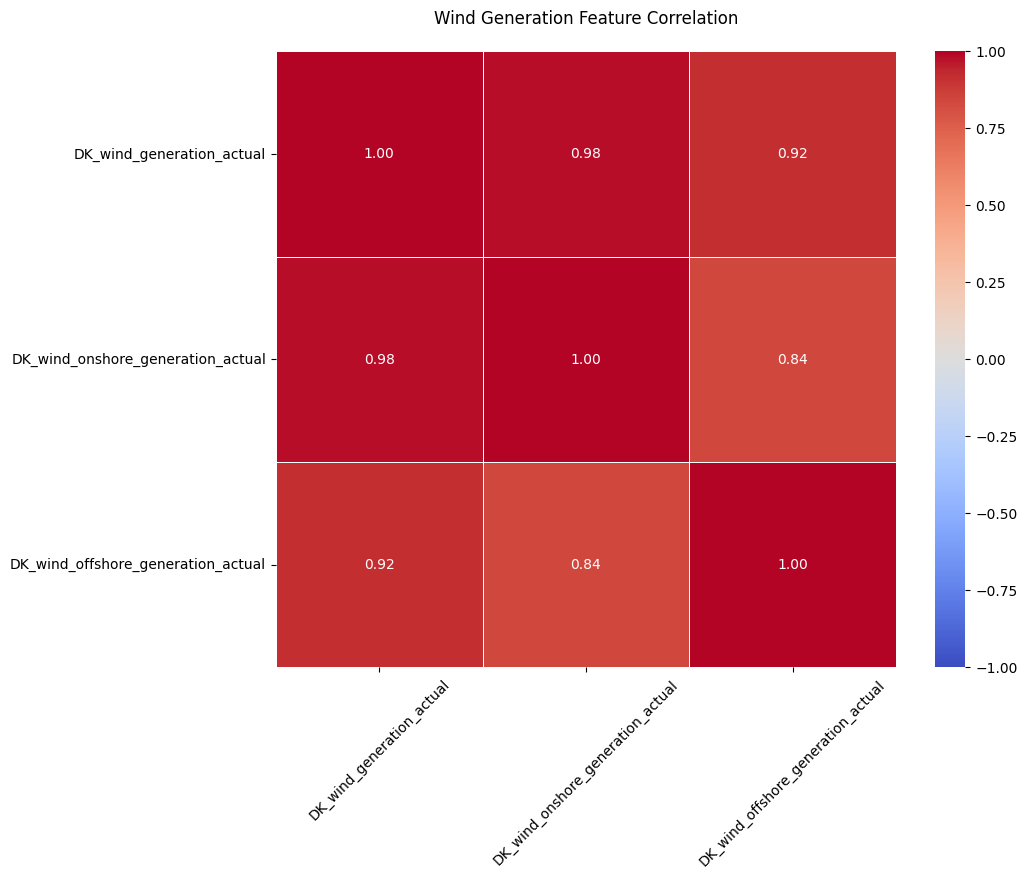

In [12]:
wind_df = dk_data[wind_cols].copy()

corr_matrix = wind_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, vmax=1,
            fmt=".2f",
            linewidths=0.5)
plt.title('Wind Generation Feature Correlation', pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [13]:
pca = PCA(n_components=1)
dk_data['DK_wind_pca'] = pca.fit_transform(StandardScaler().fit_transform(dk_data[wind_cols]))

In [14]:
print(f"\nExplained variance by PCA: {pca.explained_variance_ratio_[0]:.2%}")
dk_data.head()


Explained variance by PCA: 94.31%


,utc_timestamp,DK_load_actual_entsoe_transparency,DK_solar_generation_actual,DK_wind_generation_actual,DK_wind_offshore_generation_actual,DK_wind_onshore_generation_actual,DK_wind_pca
1,2015-01-01 01:00:00+00:00,3100.02,0.00,2357.33,902.71,1454.62,1.105387
2,2015-01-01 02:00:00+00:00,2980.39,0.00,2387.35,830.87,1556.48,1.085971
3,2015-01-01 03:00:00+00:00,2933.49,0.00,2594.47,915.43,1679.04,1.393995
4,2015-01-01 04:00:00+00:00,2941.54,0.01,3092.01,1056.28,2035.73,2.086482
5,2015-01-01 05:00:00+00:00,2999.89,0.01,3270.63,1068.07,2202.56,2.305552


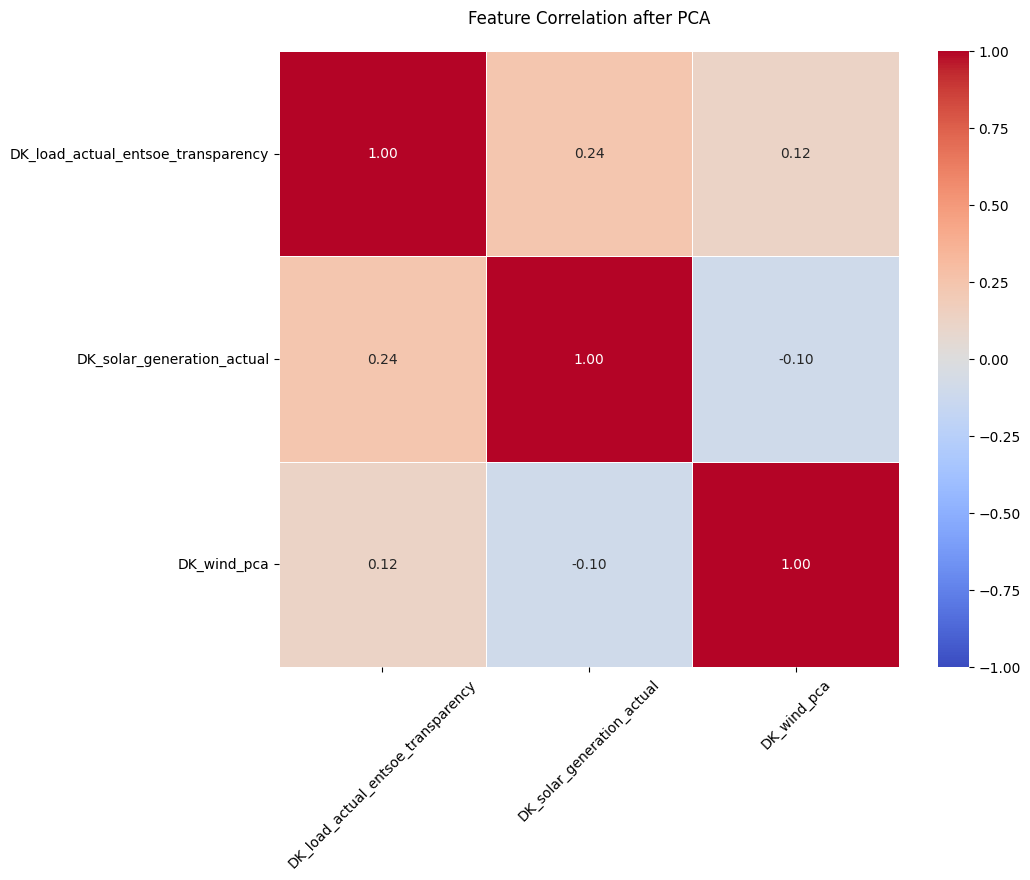

In [15]:
wind_pca_cols = [
    "DK_load_actual_entsoe_transparency",
    "DK_solar_generation_actual",
    "DK_wind_pca"
]

wind_df = dk_data[wind_pca_cols].copy()

corr_matrix = wind_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, 
            annot=True, 
            cmap='coolwarm', 
            vmin=-1, vmax=1,
            fmt=".2f",
            linewidths=0.5)
plt.title('Feature Correlation after PCA', pad=20)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.show()

In [16]:
original_wind_data = dk_data[[
    'DK_wind_generation_actual',
    'DK_wind_onshore_generation_actual',
    'DK_wind_offshore_generation_actual'
]].copy()

dk_data.drop([
    'DK_wind_generation_actual',
    'DK_wind_onshore_generation_actual',
    'DK_wind_offshore_generation_actual'
], axis=1, inplace=True)

## 3. Form 24-Hour Arrays

In [17]:
dk_data['date'] = dk_data['utc_timestamp'].dt.date

def create_daily_arrays(group):
        """Convert hourly data to 24-hour arrays for each day"""
        if len(group) == 24:
            return group[['DK_load_actual_entsoe_transparency',
                         'DK_solar_generation_actual',
                         'DK_wind_pca']].values
        return None

daily_data = dk_data.groupby('date').apply(lambda x: create_daily_arrays(x)).dropna()

daily_arrays = np.stack(daily_data.values)
print(f"Shape of daily arrays: {daily_arrays.shape} (days, hours, features)")

Shape of daily arrays: (2098, 24, 3) (days, hours, features)


C:\Users\User\AppData\Local\Temp\ipykernel_12084\582854407.py:11: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  daily_data = dk_data.groupby('date').apply(lambda x: create_daily_arrays(x)).dropna()


In [18]:
random_indices = random.sample(range(len(daily_arrays)), 5)

for i, index in enumerate(random_indices):
    print(f"\nDay ({daily_data.index[index]}):")
    print("Hour | Load   | Solar | Wind PCA")
    print("-------------------------------")
    for hour in range(24):
        print(f"{hour:2}:00 | {daily_arrays[index,hour,0]:6.1f} | "
              f"{daily_arrays[i,hour,1]:5.2f} | "
              f"{daily_arrays[i,hour,2]:6.3f}")
    if i < 4: print("\n" + "-"*40)


Day (2018-10-08):
Hour | Load   | Solar | Wind PCA
-------------------------------
 0:00 | 2746.0 |  0.00 |  1.947
 1:00 | 2746.7 |  0.00 |  1.922
 2:00 | 2872.2 |  0.00 |  1.889
 3:00 | 3135.7 |  0.01 |  1.866
 4:00 | 3793.1 |  0.01 |  2.282
 5:00 | 4445.7 |  0.01 |  3.628
 6:00 | 4614.9 |  0.01 |  3.725
 7:00 | 4595.7 |  0.06 |  3.736
 8:00 | 4634.7 |  4.76 |  3.690
 9:00 | 4624.1 | 29.04 |  3.640
10:00 | 4560.3 | 70.30 |  3.598
11:00 | 4563.6 | 77.66 |  3.464
12:00 | 4467.3 | 68.74 |  3.506
13:00 | 4320.0 | 35.44 |  3.541
14:00 | 4328.9 |  6.91 |  3.497
15:00 | 4626.1 |  0.08 |  3.482
16:00 | 4628.2 |  0.01 |  3.503
17:00 | 4445.3 |  0.01 |  3.546
18:00 | 4165.0 |  0.01 |  3.479
19:00 | 3892.4 |  0.01 |  3.277
20:00 | 3540.3 |  0.00 |  3.462
21:00 | 3217.9 |  0.00 |  3.429
22:00 | 3039.6 |  0.00 |  3.128
23:00 | 2976.1 |  0.00 |  3.255

----------------------------------------

Day (2019-03-20):
Hour | Load   | Solar | Wind PCA
-------------------------------
 0:00 | 3166.0 |  0.00

## 4. Label Seasons

In [19]:
def get_season(date):
    """Map date to season"""
    month = date.month
    if 3 <= month <= 5:
        return 'spring'
    elif 6 <= month <= 8:
        return 'summer'
    elif 9 <= month <= 11:
        return 'fall'
    else:
        return 'winter'

In [20]:
seasons = [get_season(date) for date in daily_data.index]
seasons = pd.Series(seasons, index=daily_data.index)

season_counts = pd.Series(seasons).value_counts()
print("Season distribution:")
print(season_counts)

Season distribution:
spring    552
summer    552
winter    510
fall      484
Name: count, dtype: int64


## 5. Train-test split

In [21]:
dates = daily_data.index.repeat(24)
hours = np.tile(np.arange(24), len(daily_data))

data_flat = daily_arrays.reshape(-1, 3)  # Reshape to 2D (days*hours, features)

dk_data = pd.DataFrame(
    data_flat,
    columns=['DK_load_actual_entsoe_transparency', 'DK_solar_generation_actual', 'DK_wind_pca'],
)

dk_data['Date'] = dates
dk_data['Hour'] = hours
season_flat = seasons.repeat(24).values
dk_data['Season'] = season_flat

dk_data = dk_data[['Date', 'Hour',
                   'DK_load_actual_entsoe_transparency', 
                   'DK_solar_generation_actual', 
                   'DK_wind_pca', 'Season']]

dk_data

,Date,Hour,DK_load_actual_entsoe_transparency,DK_solar_generation_actual,DK_wind_pca,Season
0,2015-01-02,0,2996.22,0.00,1.946609,winter
1,2015-01-02,1,2942.88,0.00,1.922296,winter
2,2015-01-02,2,2944.18,0.00,1.888987,winter
3,2015-01-02,3,3019.46,0.01,1.865681,winter
4,2015-01-02,4,3104.17,0.01,2.282396,winter
...,...,...,...,...,...,...
50347,2020-09-29,19,3793.50,0.00,-1.177267,fall
50348,2020-09-29,20,3373.40,0.00,-1.368210,fall
50349,2020-09-29,21,3107.03,0.00,-1.407722,fall
50350,2020-09-29,22,2978.80,0.00,-1.479454,fall


In [22]:
daily_groups = dk_data.groupby('Date')

X = np.stack([group[['DK_load_actual_entsoe_transparency', 
                    'DK_solar_generation_actual', 
                    'DK_wind_pca']].values.flatten() 
              for _, group in daily_groups])

y = daily_groups.first()['Season'].values

le = LabelEncoder()
y_encoded = le.fit_transform(y)  # winter=0, spring=1, summer=2, fall=3

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y_encoded, test_size=0.3, stratify=y_encoded, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

## 6. Data scaling

In [23]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f"Train shapes: {X_train_scaled.shape}, {y_train.shape}")
print(f"Val shapes: {X_val_scaled.shape}, {y_val.shape}")
print(f"Test shapes: {X_test_scaled.shape}, {y_test.shape}")

Train shapes: (1468, 72), (1468,)
Val shapes: (315, 72), (315,)
Test shapes: (315, 72), (315,)


## 7. Brief Analysis

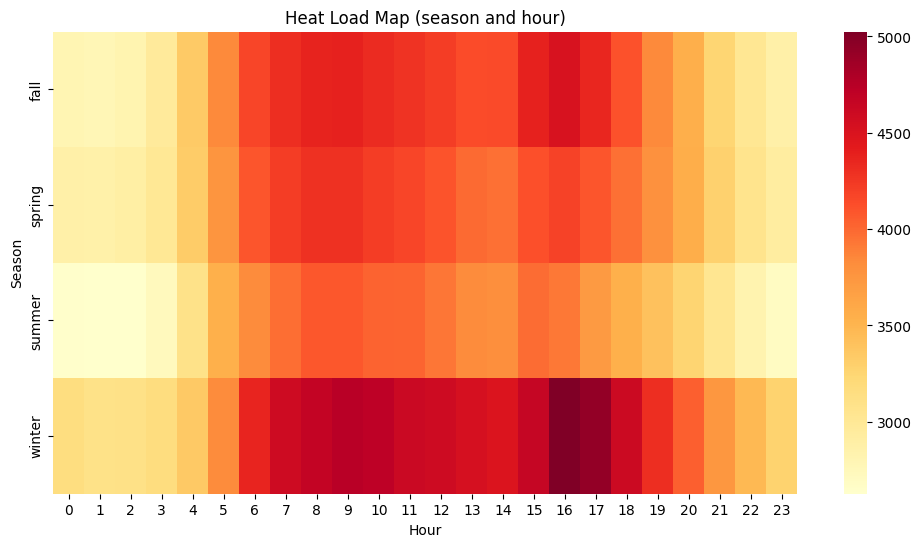

In [24]:
seasonal_hourly = dk_data.groupby(['Season', 'Hour'])['DK_load_actual_entsoe_transparency'].mean().unstack()

plt.figure(figsize=(12, 6))
sns.heatmap(seasonal_hourly, cmap='YlOrRd', annot=False, fmt='.0f')
plt.title('Heat Load Map (season and hour)')
plt.savefig('heatmap_seasonal_hourly.png', dpi=300)
plt.show()

### Observations: 

1. **Seasonal dependency**:  
   - Winter demand exceeds summer by **40–50%**  
   - Clear correlation between weather extremes and energy needs   

2. **Renewable integration**:  
   - Summer solar potential aligns with midday cooling demand  
   - Winter wind patterns complement evening heating needs   

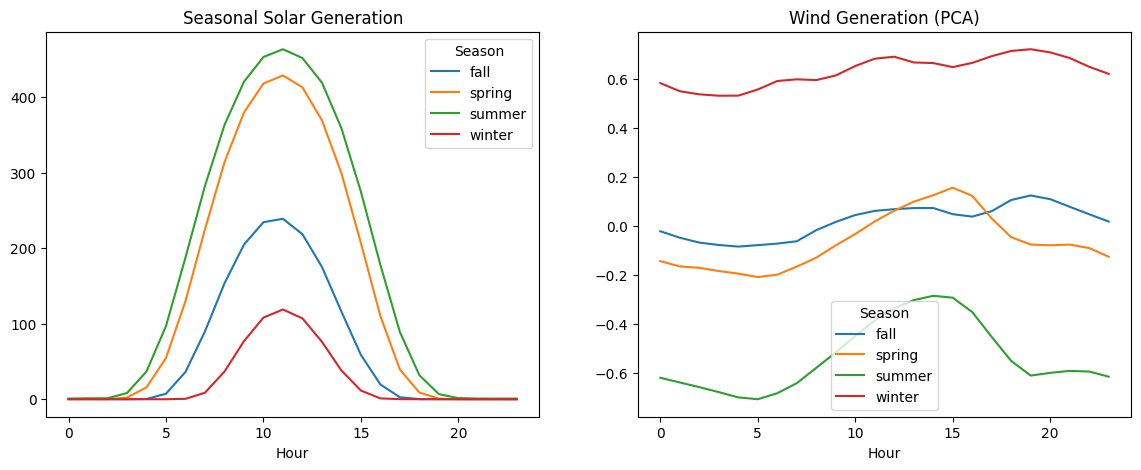

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

dk_data.groupby(['Season', 'Hour'])['DK_solar_generation_actual'].mean().unstack().T.plot(ax=ax1)
ax1.set_title('Seasonal Solar Generation')

dk_data.groupby(['Season', 'Hour'])['DK_wind_pca'].mean().unstack().T.plot(ax=ax2)
ax2.set_title('Wind Generation (PCA)')

plt.savefig('renewable_comparison.png', dpi=300)
plt.show()

### Observations: 

1. **Solar and Wind Generations are complementary**:  
   - When solar is low (winter), wind activity increases, and vice versa in summer  

2. **Negative PCA values dominate**:  
   - Fall/Winter Wind Generation display stronger wind patterns (negative PCA values dominate), likely due to storm systems 

Obviously, solar energy production is much higher in summer/spring, and it's minimal in winter. 

# Task 2: Baseline MLP (Fully-Connected Network)

## 1. Implement an MLP in PyTorch

In [26]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [27]:
class SeasonalMLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(SeasonalMLP, self).__init__()
        # Captures high-dimensional patterns from 24h sequences of 3 features
        # Input layer -> Hidden layer with ReLU -> Output layer
        self.input = nn.Linear(input_size, 128)
        self.hidden1 = nn.Linear(128, 64)
        self.hidden2 = nn.Linear(64, 32)
        self.output = nn.Linear(32, num_classes)
        
    def forward(self, x):
        x = F.relu(self.input(x))
        x = F.relu(self.hidden1(x))
        x = F.relu(self.hidden2(x))
        x = self.output(x)
        return F.log_softmax(x, dim=1)

## 2. Input Representation

In [28]:
print(f"Training sample size: {len(X_train)} examples")
print(f"Number of features: {X_train.shape[1]}")

Training sample size: 1468 examples
Number of features: 72


The optimal `batch_size` value will be 32 based on the size of the training sample.

In [29]:
def loader_creator(x_train, y_train, x_val, y_val, x_test, y_test):
    batch_size = 32

    X_train_tensor = torch.FloatTensor(x_train)
    y_train_tensor = torch.LongTensor(y_train)
    X_val_tensor = torch.FloatTensor(x_val)
    y_val_tensor = torch.LongTensor(y_val)
    X_test_tensor = torch.FloatTensor(x_test)
    y_test_tensor = torch.LongTensor(y_test)


    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

    return DataLoader(train_dataset, batch_size, shuffle=True), DataLoader(val_dataset, batch_size), DataLoader(test_dataset, batch_size)

In [30]:
train_loader, val_loader, test_loader = loader_creator(X_train_scaled, y_train, X_val_scaled, y_val, X_test_scaled, y_test)

In [31]:
input_size = X_train_scaled.shape[1]
num_classes = 4

epochs = 100

model = SeasonalMLP(input_size, num_classes).to(device)

# standard for multi-class problems, as it combines softmax activation with negative log-likelihood
# effectively handling class probabilities
criterion = nn.CrossEntropyLoss()

# offering faster convergence than SGD for sparse temporal data like energy records
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
val_accuracies = []

## 3. Train & Evaluate

In [32]:
def train(model, device, train_loader, optimizer):
    model.train()
    overall_loss = 0.0
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)

        optimizer.zero_grad()
        output = model(data)
        
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        
        overall_loss += loss.item()
    
    train_loss = overall_loss / len(train_loader)
    train_losses.append(train_loss)
    return train_loss

In [33]:
def val_test(model, device, loader, epoch=0, description=True):
    model.eval()
    loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in loader:
            data, target = data.to(device), target.to(device)
            output = model(data)

            loss += F.nll_loss(output, target, reduction='sum').item()  
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    loss /= len(loader.dataset)

    val_accuracy = correct / len(loader.dataset)
    val_accuracies.append(val_accuracy)

    if description:
        print(f"Validation set {epoch}: Average loss: {loss:.4f}, Accuracy: {100. * val_accuracy:.2f}%")

    return loss, val_accuracy

In [34]:
for epoch in range(1, epochs + 1):
    train(model, device, train_loader, optimizer)
    val_test(model, device, val_loader, epoch)

Validation set 1: Average loss: 0.8941, Accuracy: 60.63%
Validation set 2: Average loss: 0.6754, Accuracy: 70.79%
Validation set 3: Average loss: 0.6122, Accuracy: 72.06%
Validation set 4: Average loss: 0.5336, Accuracy: 76.83%
Validation set 5: Average loss: 0.5214, Accuracy: 78.10%
Validation set 6: Average loss: 0.5461, Accuracy: 76.51%
Validation set 7: Average loss: 0.4846, Accuracy: 80.00%
Validation set 8: Average loss: 0.4404, Accuracy: 80.32%
Validation set 9: Average loss: 0.4716, Accuracy: 82.22%
Validation set 10: Average loss: 0.4192, Accuracy: 81.59%
Validation set 11: Average loss: 0.4069, Accuracy: 83.17%
Validation set 12: Average loss: 0.4099, Accuracy: 83.17%
Validation set 13: Average loss: 0.4002, Accuracy: 82.54%
Validation set 14: Average loss: 0.3667, Accuracy: 85.40%
Validation set 15: Average loss: 0.4001, Accuracy: 83.81%
Validation set 16: Average loss: 0.3703, Accuracy: 85.40%
Validation set 17: Average loss: 0.3541, Accuracy: 84.13%
Validation set 18: Aver

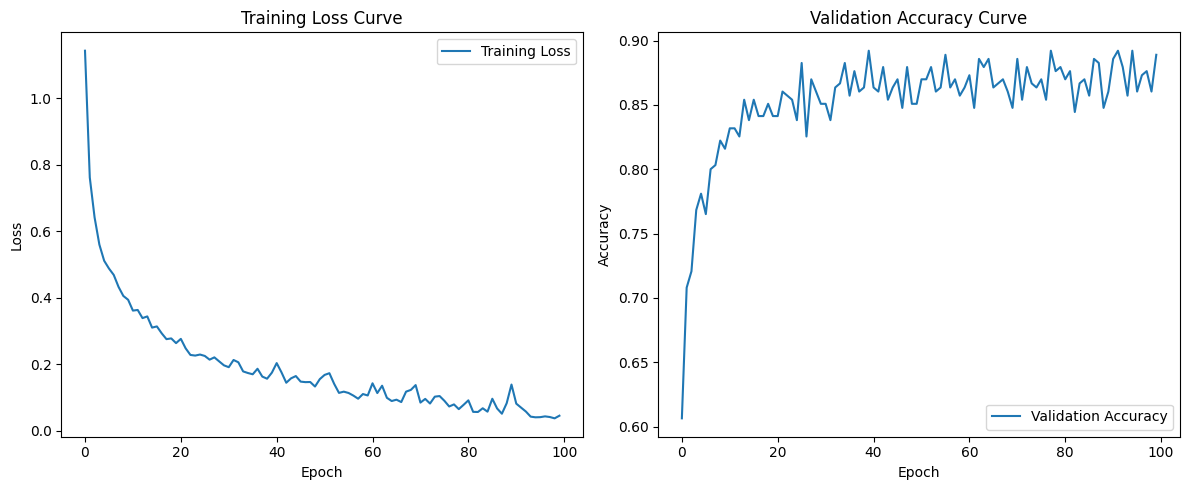

In [35]:
# Plot training curves
def plot_curves(train_losses, val_accuracies):
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(train_losses, label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss Curve')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(val_accuracies, label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Validation Accuracy Curve')
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_curves(train_losses, val_accuracies)

Final Accuracy: 0.8540


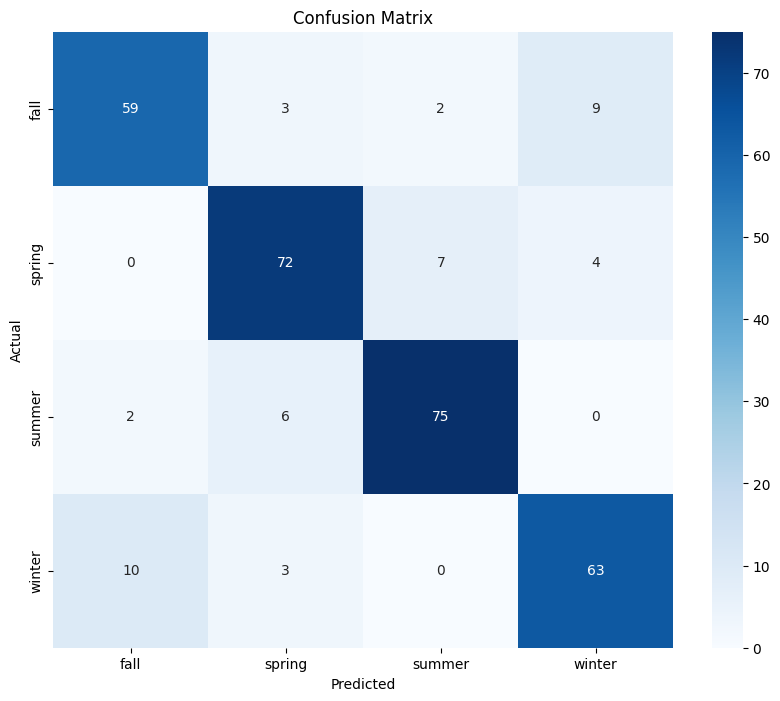


Class-wise Performance:
        total  correct  accuracy
Actual                          
fall       73       59  0.808219
spring     83       72  0.867470
summer     83       75  0.903614
winter     76       63  0.828947


In [36]:
model.eval()
all_predicted = []
all_labels = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = model(data)
        _, predicted = torch.max(output.data, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

test_predictions = le.inverse_transform(all_predicted)
test_actual = le.inverse_transform(all_labels)

final_accuracy_mlp = accuracy_score(test_actual, test_predictions)
print(f"Final Accuracy: {final_accuracy_mlp:.4f}")

plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_actual, test_predictions, labels=le.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

error_df = pd.DataFrame({
    'Actual': test_actual,
    'Predicted': test_predictions,
    'Correct': test_actual == test_predictions
})

class_stats = error_df.groupby('Actual').agg(
    total=('Correct', 'count'),
    correct=('Correct', 'sum'),
    accuracy=('Correct', 'mean')
)
print("\nClass-wise Performance:")
print(class_stats)

# Task 3: 1D-CNN on Raw Time-Series

## 1. 1D Convolution Architecture

In [37]:
class SeasonalCNN1D(nn.Module):
    def __init__(self, num_channels=3, num_classes=4, 
                 kernel_size=3, dropout_rate=0.25, use_bn=True):
        super(SeasonalCNN1D, self).__init__()
        
        self.kernel_size = kernel_size
        self.padding = kernel_size // 2
        
        # --- Conv Block 1 ---
        # (batch, 3, 24) -> (batch, 16, 24) (padding)
        # (batch, 16, 24) -> (batch, 16, 12) (MaxPool)
        self.conv1 = nn.Sequential(
            nn.Conv1d(num_channels, 16, kernel_size, padding=self.padding),
            nn.BatchNorm1d(16) if use_bn else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool1d(2),
        )
        
        # --- Conv Block 2 ---
        # (batch, 16, 12) -> (batch, 32, 12) (padding)
        # (batch, 32, 12) -> (batch, 32, 6) (MaxPool)
        self.conv2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size, padding=self.padding),
            nn.BatchNorm1d(32) if use_bn else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool1d(2),
            nn.Dropout(dropout_rate)
        )
        
        # --- Conv Block 3 ---
        # (batch, 32, 6) -> (batch, 64, 6) (padding)
        self.conv3 = nn.Sequential(
            nn.Conv1d(32, 64, kernel_size, padding=self.padding),
            nn.BatchNorm1d(64) if use_bn else nn.Identity(),
            nn.ReLU(),
        )
        
        self.flattened_size = 64 * 6
        
        self.linear1 = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = torch.flatten(x, 1)  # (batch, 64*6)
        x = self.linear1(x)
        return F.log_softmax(x, dim=1)

In [38]:
import operator
class EarlyStopping():
    def __init__(self, tolerance=5, min_delta=0, mode='min'):
        self.early_stop = False
        self.tolerance = tolerance
        self.min_delta = min_delta
        self.mode = mode
        self.counter = 0
        self.best_metric = np.inf if mode == 'min' else -np.inf
        self.operation = operator.gt if mode == 'min' else operator.lt
        pass
    
    def __call__(self, metric)->bool:
        delta = (metric - self.best_metric)

        if self.operation(self.min_delta, delta):
            self.best_metric = metric
            self.counter = 0
        else:
            self.counter += 1

        if self.counter >= self.tolerance:
            self.early_stop = True
        return self.early_stop

In [39]:
# standard for multi-class problems, as it combines softmax activation with negative log-likelihood
# effectively handling class probabilities
criterion = nn.CrossEntropyLoss()

patience = 10  # for early stopping
epochs = 100

In [40]:
X_train_3d = X_train_scaled.reshape(-1, 24, 3).transpose(0, 2, 1)  # (1468, 3, 24)
X_val_3d = X_val_scaled.reshape(-1, 24, 3).transpose(0, 2, 1)      # (315, 3, 24)
X_test_3d = X_test_scaled.reshape(-1, 24, 3).transpose(0, 2, 1)    # (315, 3, 24)

train_loader, val_loader, test_loader = loader_creator(X_train_3d, y_train, X_val_3d, y_val, X_test_3d, y_test)

## 2. Hyperparameter Tuning

In [41]:
param_grid = {
    'kernel_size': [3, 5],
    'dropout_rate': [0.1, 0.25, 0.4],
    'use_bn': [True, False],
    'learning_rate': [0.001, 0.0005],
}

def run_training(params, model_name='SeasonalCNN1D'):
    model = globals()[model_name](
        kernel_size=params['kernel_size'],
        dropout_rate=params['dropout_rate'],
        use_bn=params['use_bn']
    ).to(device)
    
    optimizer = optim.Adam(model.parameters(), lr=params['learning_rate'])
    early_stopping = EarlyStopping(tolerance=patience)
    
    best_val_loss = float('inf')
    best_model = None
    train_losses_CNN = []
    val_losses_CNN = []
    val_accuracies_CNN = []
    
    for epoch in range(epochs):
        train_loss = train(model, device, train_loader, optimizer)
        train_losses_CNN.append(train_loss)
        
        val_loss, val_accuracy = val_test(model, device, val_loader, epoch, description=False)
        val_losses_CNN.append(val_loss)
        val_accuracies_CNN.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{epochs} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.4f}")
        
        if early_stopping(val_loss):
            print(f"Early stopping triggered at epoch {epoch+1}")
            break
            
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = deepcopy(model.state_dict())
    
    model.load_state_dict(best_model)
    
    return {
        'model': model,
        'train_losses': train_losses_CNN,
        'val_losses': val_losses_CNN,
        'val_accuracies': val_accuracies_CNN,
        'best_val_loss': best_val_loss,
        'best_val_accuracy': max(val_accuracies_CNN),
        'params': params
    }

In [42]:
def hyperparameter_tuning(model_name='SeasonalCNN1D'):
    results = []
    param_combinations = list(ParameterGrid(param_grid))
    total_combinations = len(param_combinations)
    
    print(f"Starting hyperparameter tuning with {total_combinations} combinations")
    
    for i, params in enumerate(param_combinations):
        print(f"\nRunning combination {i+1}/{total_combinations}: {params}")
        result = run_training(params, model_name=model_name)
        results.append(result)
        
        print(f"Best Val Loss: {result['best_val_loss']:.4f}, Best Val Acc: {result['best_val_accuracy']:.4f}")
    
    best_result = min(results, key=lambda x: x['best_val_loss'])
    print("\nHyperparameter tuning complete!")
    print(f"Best configuration: {best_result['params']}")
    print(f"Best validation loss: {best_result['best_val_loss']:.4f}")
    print(f"Best validation accuracy: {best_result['best_val_accuracy']:.4f}")
    
    return best_result

## 3. Comparison vs. MLP 

### ⚠️ Important Notice Before Running Hyperparameter Tuning

**Approximate duration:** ~8 minutes  
**Key factors affecting runtime:**
- Total parameter combinations: 24 (2 kernel sizes × 3 dropout rates × 2 BN options × 2 learning rates)
- Training epochs: 100 (with early stopping)

In [43]:
best_result = hyperparameter_tuning()
best_model = best_result['model']

best_val_accuracy = best_result['best_val_accuracy']

Starting hyperparameter tuning with 24 combinations

Running combination 1/24: {'dropout_rate': 0.1, 'kernel_size': 3, 'learning_rate': 0.001, 'use_bn': True}
Epoch 1/100 - Train Loss: 0.8984, Val Loss: 0.7609, Val Acc: 0.7238
Epoch 2/100 - Train Loss: 0.6620, Val Loss: 0.6176, Val Acc: 0.7429
Epoch 3/100 - Train Loss: 0.5495, Val Loss: 0.5532, Val Acc: 0.7556
Epoch 4/100 - Train Loss: 0.4973, Val Loss: 0.5041, Val Acc: 0.7937
Epoch 5/100 - Train Loss: 0.4766, Val Loss: 0.4838, Val Acc: 0.7968
Epoch 6/100 - Train Loss: 0.4330, Val Loss: 0.4399, Val Acc: 0.8095
Epoch 7/100 - Train Loss: 0.4011, Val Loss: 0.4861, Val Acc: 0.7968
Epoch 8/100 - Train Loss: 0.3682, Val Loss: 0.4229, Val Acc: 0.8317
Epoch 9/100 - Train Loss: 0.3564, Val Loss: 0.4021, Val Acc: 0.8413
Epoch 10/100 - Train Loss: 0.3426, Val Loss: 0.3851, Val Acc: 0.8286
Epoch 11/100 - Train Loss: 0.3326, Val Loss: 0.3849, Val Acc: 0.8413
Epoch 12/100 - Train Loss: 0.3212, Val Loss: 0.4125, Val Acc: 0.8254
Epoch 13/100 - Train L

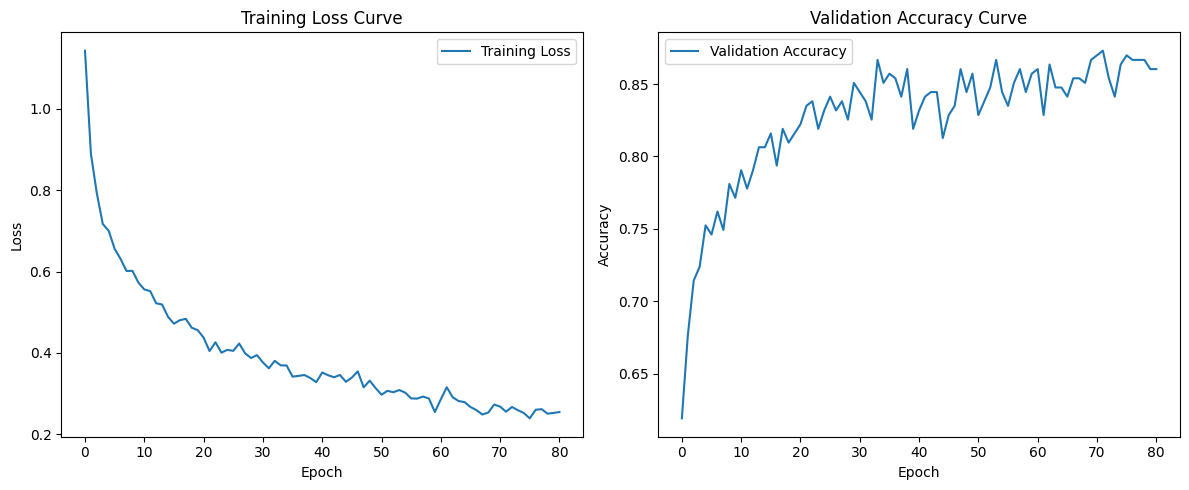

In [44]:
plot_curves(best_result['train_losses'], best_result['val_accuracies'])

In [45]:
best_model.eval()
all_predicted = []
all_labels = []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = best_model(data)
        _, predicted = torch.max(output.data, 1)
        all_predicted.extend(predicted.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

test_predictions = le.inverse_transform(all_predicted)
test_actual = le.inverse_transform(all_labels)

final_accuracy_cnn_1d = accuracy_score(test_actual, test_predictions)
print(f"Final Test Accuracy: {final_accuracy_cnn_1d:.4f}")

Final Test Accuracy: 0.8794


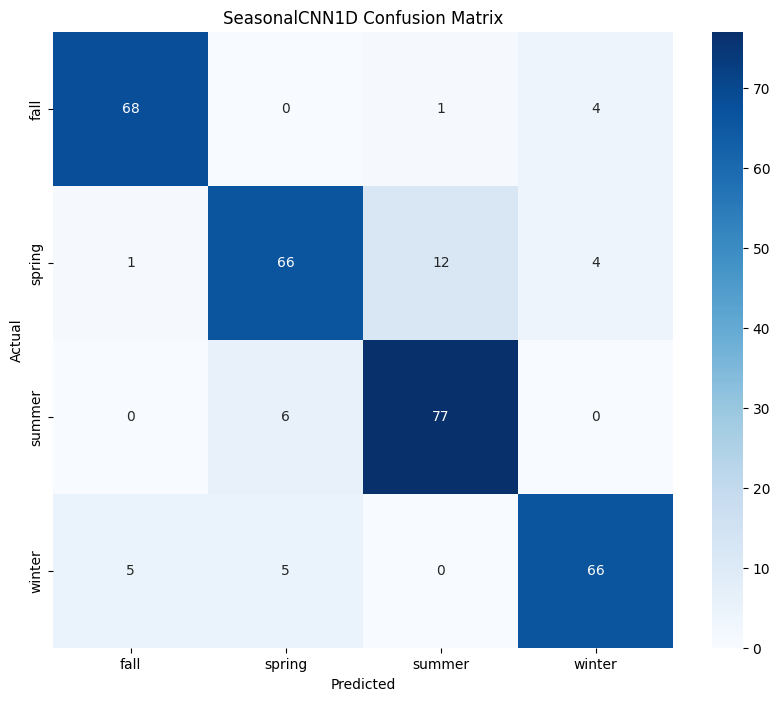


Class-wise Performance CNN 1D:
        total  correct  accuracy
Actual                          
fall       73       68  0.931507
spring     83       66  0.795181
summer     83       77  0.927711
winter     76       66  0.868421


In [46]:
plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_actual, test_predictions, labels=le.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SeasonalCNN1D Confusion Matrix')
plt.show()

error_df = pd.DataFrame({
    'Actual': test_actual,
    'Predicted': test_predictions,
    'Correct': test_actual == test_predictions
})

class_stats = error_df.groupby('Actual').agg(
    total=('Correct', 'count'),
    correct=('Correct', 'sum'),
    accuracy=('Correct', 'mean')
)
print("\nClass-wise Performance CNN 1D:")
print(class_stats)

In [47]:
print(f"\nPerformance Comparison:")
print(f"SeasonalCNN1D Test Accuracy: {final_accuracy_cnn_1d:.4f}")
print(f"MLP Test Accuracy: {final_accuracy_mlp:.4f}")
print(f"Accuracy Improvement: {(final_accuracy_cnn_1d - final_accuracy_mlp):.4f} ({((final_accuracy_cnn_1d - final_accuracy_mlp)/final_accuracy_mlp*100):.2f}%)")


Performance Comparison:
SeasonalCNN1D Test Accuracy: 0.8794
MLP Test Accuracy: 0.8540
Accuracy Improvement: 0.0254 (2.97%)


# Task 4: 2D Transform & 2D-CNN

## 1. Transformation & 2D Convolution Architecture

In [48]:
gaf = GramianAngularField(method='summation', image_size=24)

In [49]:
def create_2d_representation(X_3d):
    n_samples, n_channels, _ = X_3d.shape
    X_2d = np.zeros((n_samples, n_channels, 24, 24))
    
    for i in range(n_samples):
        for c in range(n_channels):
            X_2d[i,c] = gaf.fit_transform(X_3d[i,c].reshape(1, -1))
    
    return X_2d

In [50]:
class SeasonalCNN2D(nn.Module):
    def __init__(self, num_channels=3, num_classes=4, 
             kernel_size=5, dropout_rate=0.25, use_bn=True):
        super(SeasonalCNN2D, self).__init__()
        
        self.conv1 = nn.Sequential(
            nn.Conv2d(num_channels, 16, kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(16) if use_bn else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size, padding=kernel_size//2),
            nn.BatchNorm2d(32) if use_bn else nn.Identity(),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Dropout(dropout_rate)
        )

        self.flattened_size = 32 * 6 * 6
        
        self.classifier = nn.Sequential(
            nn.Linear(self.flattened_size, 256),
            nn.ReLU(),
            nn.Dropout(dropout_rate/2),
            nn.Linear(256, num_classes)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return F.log_softmax(x, dim=1)


In [51]:
X_train_2d = create_2d_representation(X_train_3d)
X_val_2d = create_2d_representation(X_val_3d)
X_test_2d = create_2d_representation(X_test_3d)

train_loader, val_loader, test_loader = loader_creator(
    X_train_2d, y_train, X_val_2d, y_val, X_test_2d, y_test)

patience = 10
epochs = 100

## 2. Train a 2D CNN

### ⚠️ Important Notice Before Running Hyperparameter Tuning

**Approximate duration:** ~7 minutes  
**Key factors affecting runtime:**
- Total parameter combinations: 24 (2 kernel sizes × 3 dropout rates × 2 BN options × 2 learning rates)
- Training epochs: 100 (with early stopping)

In [52]:
best_result = hyperparameter_tuning("SeasonalCNN2D")
best_model = best_result['model']

best_val_accuracy = best_result['best_val_accuracy']

Starting hyperparameter tuning with 24 combinations

Running combination 1/24: {'dropout_rate': 0.1, 'kernel_size': 3, 'learning_rate': 0.001, 'use_bn': True}
Epoch 1/100 - Train Loss: 1.1021, Val Loss: 0.8246, Val Acc: 0.6476
Epoch 2/100 - Train Loss: 0.7647, Val Loss: 0.6890, Val Acc: 0.7460
Epoch 3/100 - Train Loss: 0.5728, Val Loss: 0.5499, Val Acc: 0.7937
Epoch 4/100 - Train Loss: 0.4710, Val Loss: 0.5463, Val Acc: 0.7460
Epoch 5/100 - Train Loss: 0.4423, Val Loss: 0.5376, Val Acc: 0.8000
Epoch 6/100 - Train Loss: 0.3686, Val Loss: 0.6227, Val Acc: 0.7651
Epoch 7/100 - Train Loss: 0.3228, Val Loss: 0.4851, Val Acc: 0.8190
Epoch 8/100 - Train Loss: 0.2736, Val Loss: 0.5159, Val Acc: 0.8190
Epoch 9/100 - Train Loss: 0.2448, Val Loss: 0.5278, Val Acc: 0.8222
Epoch 10/100 - Train Loss: 0.1883, Val Loss: 0.5650, Val Acc: 0.8349
Epoch 11/100 - Train Loss: 0.2834, Val Loss: 0.5379, Val Acc: 0.8063
Epoch 12/100 - Train Loss: 0.1691, Val Loss: 0.5479, Val Acc: 0.7905
Epoch 13/100 - Train L

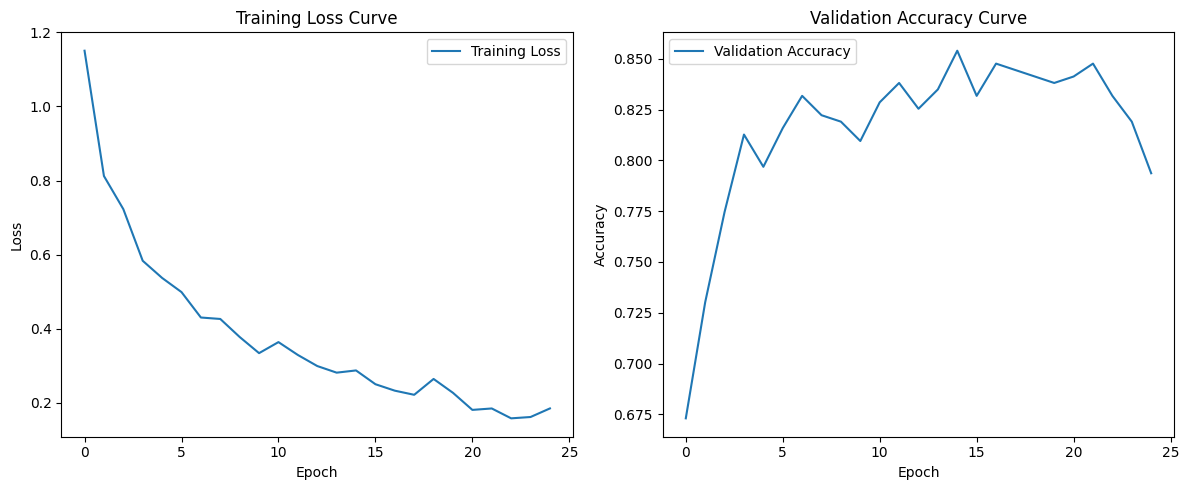

In [53]:
plot_curves(best_result['train_losses'], best_result['val_accuracies'])

In [54]:
best_model.eval()
all_preds, all_labels = [], []
with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        output = best_model(data)
        preds = output.argmax(dim=1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(target.cpu().numpy())

test_predictions = le.inverse_transform(all_preds)
test_actual = le.inverse_transform(all_labels)

final_accuracy_cnn_2d = accuracy_score(test_actual, test_predictions)
print(f"Final Test Accuracy: {final_accuracy_cnn_2d:.4f}")

Final Test Accuracy: 0.8444


## 3. Evaluate & Discuss


Performance Comparison:
SeasonalCNN1D Test Accuracy: 0.8794
MLP Test Accuracy: 0.8540
SeasonalCNN2D Test Accuracy: 0.8444
Accuracy Improvement CNN 1D vs MLP: 0.0254 (2.97%)
Accuracy Improvement CNN 2D vs MLP: -0.0095 (-1.12%)
Accuracy Improvement CNN 1D vs CNN 2D: 0.0349 (4.14%)


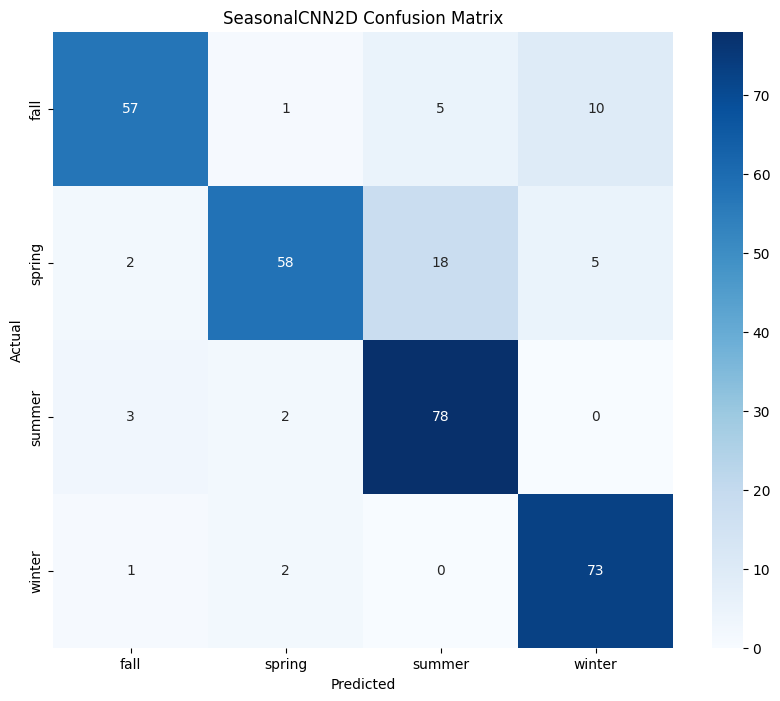


Class-wise Performance CNN 2D:
        total  correct  accuracy
Actual                          
fall       73       57  0.780822
spring     83       58  0.698795
summer     83       78  0.939759
winter     76       73  0.960526


In [55]:
print(f"\nPerformance Comparison:")
print(f"SeasonalCNN1D Test Accuracy: {final_accuracy_cnn_1d:.4f}")
print(f"MLP Test Accuracy: {final_accuracy_mlp:.4f}")
print(f"SeasonalCNN2D Test Accuracy: {final_accuracy_cnn_2d:.4f}")
print(f"Accuracy Improvement CNN 1D vs MLP: {(final_accuracy_cnn_1d - final_accuracy_mlp):.4f} ({((final_accuracy_cnn_1d - final_accuracy_mlp)/final_accuracy_mlp*100):.2f}%)")
print(f"Accuracy Improvement CNN 2D vs MLP: {(final_accuracy_cnn_2d - final_accuracy_mlp):.4f} ({((final_accuracy_cnn_2d - final_accuracy_mlp)/final_accuracy_mlp*100):.2f}%)")
print(f"Accuracy Improvement CNN 1D vs CNN 2D: {(final_accuracy_cnn_1d - final_accuracy_cnn_2d):.4f} ({((final_accuracy_cnn_1d - final_accuracy_cnn_2d)/final_accuracy_cnn_2d*100):.2f}%)")


plt.figure(figsize=(10, 8))
cm = confusion_matrix(test_actual, test_predictions, labels=le.classes_)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('SeasonalCNN2D Confusion Matrix')
plt.show()

error_df = pd.DataFrame({
    'Actual': test_actual,
    'Predicted': test_predictions,
    'Correct': test_actual == test_predictions
})

class_stats = error_df.groupby('Actual').agg(
    total=('Correct', 'count'),
    correct=('Correct', 'sum'),
    accuracy=('Correct', 'mean')
)
print("\nClass-wise Performance CNN 2D:")
print(class_stats)